# **DIVE INTO CODE COURSE**
## **Sprint Deep Learning - Neural Network**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import random
from math import log2

plt.style.use('ggplot')

**Dataset Preparation**

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
print(X_train.shape) # (60000, 28, 28)
print(y_train.shape) # (10000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_test.shape)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8


**Smoothing**

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

**Visualization**

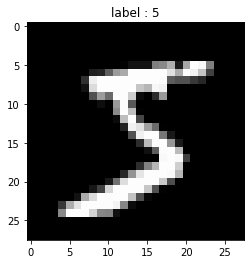

In [6]:
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

**Preprocessing**

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print("Original label: {}".format(y_train.shape)) # (60000,)
print("One hot train label: {}".format(y_train_one_hot.shape)) # (60000, 10)
print("One hot test label: {}".format(y_test_one_hot.shape))

Original label: (60000,)
One hot train label: (60000, 10)
One hot test label: (10000, 10)


**Transpose**

In [9]:
X_train = X_train.T
X_test = X_test.T
y_train_one_hot = y_train_one_hot.T
y_test_one_hot = y_test_one_hot.T

In [10]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("Train data: ", X_train.shape)
print("Test data: ", X_test.shape)
print("Train label: ", y_train_one_hot.shape)
print("Test label: ", y_test_one_hot.shape)

Train data:  (784, 60000)
Test data:  (784, 10000)
Train label:  (10, 60000)
Test label:  (10, 10000)


In [11]:
def GetMiniBatch(X, Y, batch_size):
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    mini_batches = []
    m = X.shape[1]
    # Shuffle
    permute = np.random.permutation(m)
    X = X[:,permute]
    Y = Y[:,permute]
    
    # Partition
    complete_batches = math.floor(m/batch_size)
    for k in range(complete_batches):
        batch_X = X[:,k*batch_size:(k+1)*batch_size]
        batch_Y = Y[:,k*batch_size:(k+1)*batch_size]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    # Handling the end case
    if m % batch_size != 0:
        batch_X = X[:,(k+1)*batch_size:]
        batch_Y = Y[:,(k+1)*batch_size:]
        batch = (batch_X,batch_Y)
        mini_batches.append(batch)
        
    return mini_batches

### **[Problem 1 2 3 4 5 6 7 8]**

**ReLu Function**

In [12]:
def relu_function(X):
    return np.maximum(0,X)

In [13]:
y_relu = relu_function(X_train)
print("Mininum value of y label: ", np.min(y_relu))

Mininum value of y label:  0.0


**Neural Network Class**

In [52]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    Deep neural network classifier with configurable structure
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, layers, lr=0.001, hidden_est='tanh', output_est='relu', batch_size=20, epochs=5, verbose=True):

        self.layers = layers
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.hidden_est = hidden_est
        self.output_est = output_est
        self.ssw = 0 # Sum of squared weight
        self.ssb = 0 # sum of squared bias
        self.lr_w = [] # History of weight learning rate
        self.lr_b = [] # History of weight learning rate

        self.param = {}
        self.loss = []
        self.n_features = None
        self.X_train = None
        self.y_train = None


    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """

        param = self.init_weight()
        self.iter = np.ceil(X.shape[1]//self.batch_size)

        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        print("Batch size: {}".format(self.batch_size)) 
        print("Iteration: {}".format(self.iter))

        for i in range(self.epochs):
            epoch_cost = 0

            for mini_batch in get_mini_batch:
                # Forward propagation
                (mini_X_train, mini_y_train) = mini_batch

                A_last, stored_var = self.forward_propagation(mini_X_train, param)
                # Cross entropy error
                cost = self.cross_entropy_loss(mini_y_train, A_last)
                epoch_cost += cost

                # Backward propagation
                grads = self.backward_propagation(A_last, mini_y_train, stored_var, param)

                param = self.update_parameters(param, grads)
            
            self.loss.append(epoch_cost/self.iter)
            if self.verbose:
                print("Cost after epoch {}: {}".format(i, epoch_cost/self.iter))
        

        fig, axs = plt.subplots(1, 2, figsize=(18,6))
        axs[0].plot(np.squeeze(self.loss))
        axs[0].set_ylabel('Cost (per epoch)')
        axs[0].set_xlabel('Epochs')
        axs[0].set_title("Learning rate =" + str(self.lr))

        axs[1].plot(self.lr_w, label = "weight lr")
        axs[1].plot(self.lr_b, label = "bias lr")
        axs[1].set_xlabel('Learning (per mini-batch)')
        axs[1].set_xlabel('Batches')
        axs[1].set_title("AdaGrad Learning Rate")

        plt.legend()
        plt.show()

        self.param = param

        return param
    
    def xavier_val(self, n):
        """
        Initialize the standard deviation as value of Xavier
        n: Number of nodes in the previous layer
        """
        return 1/np.sqrt(n)

    def he_val(self, n):
        """
        Initialize the standard deviation as value of He
        n: Number of nodes in the previous layer
        """
        return np.sqrt(2/n)


    def init_weight(self):
        """
        Initialize the weight and bias of neural network
        """
        np.random.seed(42)
        L = len(self.layers)

        param = {}

        for l in range(L-1):
            # Hidden Layers
            if l != (L-2):
                if self.hidden_est == 'sigmoid' or 'tanh':
                    param['W' + str(l+1)] = self.xavier_val(layers[l]) * np.random.randn(self.layers[l+1], self.layers[l])
                    param['b' + str(l+1)] = self.xavier_val(layers[l]) * np.random.randn(self.layers[l+1], 1)

                elif self.hidden_est == 'relu':
                    param['W' + str(l+1)] = self.he_val(layers[l]) * np.random.randn(self.layers[l+1], self.layers[l])
                    param['b' + str(l+1)] = self.he_val(layers[l]) * np.random.randn(self.layers[l+1], 1)

            # Output Layer
            else:
                if self.output_est == 'sigmoid' or 'tanh':
                    param['W' + str(l+1)] = self.xavier_val(layers[l]) * np.random.randn(self.layers[l+1], self.layers[l])
                    param['b' + str(l+1)] = self.xavier_val(layers[l]) * np.random.randn(self.layers[l+1], 1)

                elif self.output_est == 'relu':
                    param['W' + str(l+1)] = self.he_val(layers[l]) * np.random.randn(self.layers[l+1], self.layers[l])
                    param['b' + str(l+1)] = self.he_val(layers[l]) * np.random.randn(self.layers[l+1], 1)

        return param


    def predict(self, X, param):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        probas, _ = self.forward_propagation(X, param)
        pred = np.argmax(probas,axis=0)

        return pred

    def accuracy(self, X, y, X_test, y_test, param):
        """
        Evaluate the accuracy of the neural network
        """
        pred_y = self.predict(X, param)
        train_acc = np.mean(pred_y.flatten() == y.flatten()) * 100
        print('Training set accuracy: {}%'.format(round(train_acc, 2)))

        pred_ytest = self.predict(X_test, param)
        test_acc = np.mean(pred_ytest.flatten() == y_test.flatten()) * 100
        print('Testing set accuracy: {}%'.format(round(test_acc, 2)))
        

    def relu_function(self, A):
        return np.maximum(0,A)

    def sigmoid_function(self, A):
        
        return 1/(1+np.exp(-A))

    def tanh_function(self, A):
    
        return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))

    def softmax_function(self, A):

        return np.exp(A)/(np.sum(np.exp(A), axis = 0))


    def activation_function_forward(self, A, activation):
        """
        Use the activation function for forward propagation process and also 
        return the raw output that does not goes through the activation function
        """
        Z = None
        if activation == 'sigmoid':
            Z = self.sigmoid_function(A)

        if activation == 'tanh':
            Z = self.tanh_function(A)

        if activation == 'softmax':
            Z = self.softmax_function(A)

        if activation == 'relu':
            Z = self.relu_function(A)

        return Z


    def forward_function(self, X, W, b):
        """
        The function involving the multiplication of features, weights and bias
        Then it uses the activation function to get the output value, and also
        return a set of variables to reuse in the backward propagation
        """
        A = np.dot(W, X) + b

        return A

    def forward_propagation(self, X, param):
        """
        The forward propagation process of neural network
        
        Note: Instead of creating a fixed size forward propagation,
        I manage to modify this function to fit any input of layers
        and the intial weights and bias

        (E.g: If I change to 5 layers, the model still run properly)
        """

        Z = X
        stored_var = {}
        stored_var['Z' + str(0)] = X
        L = len(param) // 2 # Because it contains both weight and bias, we divide by 2 to get length of pairs
        
        for l in range(1, L):
            # Use the previous output for the current function
            Z_prev = Z
            A = self.forward_function(Z_prev, param['W' + str(l)], param['b' + str(l)])
            stored_var['A' + str(l)] = A
            Z = self.activation_function_forward(A, activation = self.hidden_est)
            stored_var['Z' + str(l)] = Z

        # Last layer function
        A = self.forward_function(Z, param['W' + str(L)], param['b' + str(L)])
        stored_var['A' + str(L)] = A
        Z_last = self.activation_function_forward(A, activation= self.output_est)

        return Z_last, stored_var


    def activation_function_backward(self, A, activation):
        """
        Use the activation function for backward propagation process
        """
        act = None

        if activation == 'sigmoid':
            s = self.sigmoid_function(A)
            act = s * (1-s)

        if activation == 'tanh':
            s = self.tanh_function(A)
            act = (1 - s**2)

        if activation == 'relu':
            act = A
            act[act<=0] = 0
            act[act>0] = 1

        return act

    def compute_grads(self, dA, grads, param, stored_var, l, m):
        
        # Derivative of weight and bias by using gradient of function A = W.X + b
        # The formula also consist of the variables that will be used in backwardpropagation,
        # therefore we need to get save and update them in the dictionary called grads
        dW = (1/m) * np.dot(dA, stored_var['Z' + str(l-1)].T)
        grads['dW' + str(l)] = dW

        db = (1/m) * np.sum(dA, axis=1, keepdims = True)
        grads['db' + str(l)] = db
        
        dZ_prev = np.dot(param['W' + str(l)].T, dA)
        grads['dZ'+ str(l-1)] = dZ_prev

        return grads

    
    def backward_propagation(self, Z_last, Y, stored_var, param):
        """
        The backward propagation process of neural network
        
        Note: Instead of creating a fixed size backward propagation,
        I manage to modify this function to fit any input of layers
        and the intial weights and bias

        (E.g: If I change to 5 layers, the model still run properly)
        """
        grads = {}

        L = len(param) // 2
        m = Z_last.shape[1]
        dA = (Z_last - Y)


        grads = self.compute_grads(dA, grads, param, stored_var, L, m)
        
        for l in reversed(range(1, L)):
            # Use the previous output for the current function
            dZ = grads['dZ' + str(l)]
            dA = dZ * self.activation_function_backward(stored_var['A' + str(l)], activation= self.hidden_est)
            
            grads = self.compute_grads(dA, grads, param, stored_var, l, m)

        del grads['dZ0']

        return grads

    def ada_grad(self, weight, bias):
        
        self.ssw += np.mean(weight)**2
        self.ssb += np.mean(bias)**2

    def update_parameters(self, param, grads):
        """
        Update the parameter using gradient descent
        """
        L = len(param) // 2

        # We put the 1e-7 value into the AdaGrad formula to prevent zero division
        for l in range(L):
            self.ada_grad(grads['dW' + str(l+1)], grads['db' + str(l+1)])

            weight_lr = self.lr * (1/np.sqrt(self.ssw + 1e-7))
            bias_lr = self.lr * (1/np.sqrt(self.ssb + 1e-7))

            self.lr_w.append(weight_lr)
            self.lr_b.append(bias_lr)

            param["W" + str(l+1)] -= weight_lr * grads["dW" + str(l+1)]
            param["b" + str(l+1)] -= bias_lr * grads["db" + str(l+1)]

        return param


    def cross_entropy_loss(self, Y, Z_last):
        """
        The object function of the neural network
        """
        m = Y.shape[0]

        # Avoid getting infinity at logarithm function by adding 1e-7
        return (1/m) * np.mean(-np.sum(Y*np.log(Z_last + 1e-7),axis=0))


### **[Problem 9] Learning and Estimation**
**Model 1**

Number of hidden layers: 3

Layers size: [Input, 400, 200, 10]

Batch size: 20

Learning rate: 0.001

Number of epochs: 3

Hidden layer estimator: Tanh

Output layer estimator: ReLu


In [25]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.001
batch = 20
epochs = 3

nn = ScratchDeepNeuralNetrowkClassifier(layers, lr=lr, hidden_est='tanh', output_est='relu', batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iteration: 3000.0
Cost after epoch 0: 0.3363386379826091
Cost after epoch 1: 0.08370171166821556
Cost after epoch 2: 0.060859340996741604


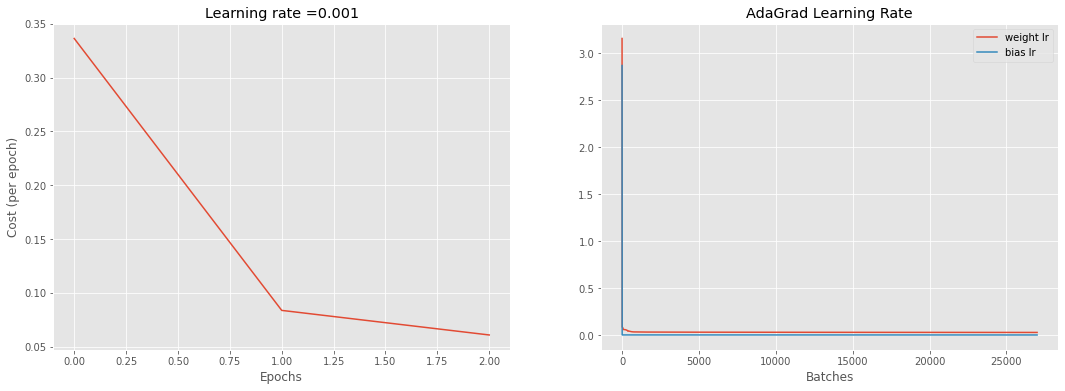

In [26]:
param = nn.fit(X_train, y_train_one_hot)

In [28]:
nn.accuracy(X_train, y_train, X_test, y_test, param)

Training set accuracy: 92.96%
Testing set accuracy: 92.82%


**Model 2**

We change the number of node in layers and activation function from tanh to sigmoid

Number of hidden layers: 3

Layers size: [Input, 300, 250, 10]

Batch size: 20

Learning rate: 0.001

Number of epochs: 3

Hidden layer estimator: Sigmoid

Output layer estimator: ReLu

In [39]:
layers = [X_train.shape[0], 300, 250, 10]
lr = 0.001
batch = 20
epochs = 3

nn2 = ScratchDeepNeuralNetrowkClassifier(layers, lr=lr, hidden_est='sigmoid', output_est='relu', batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iteration: 3000.0
Cost after epoch 0: 0.20763675157660244
Cost after epoch 1: 0.17063136626130884
Cost after epoch 2: 0.14499608763002467


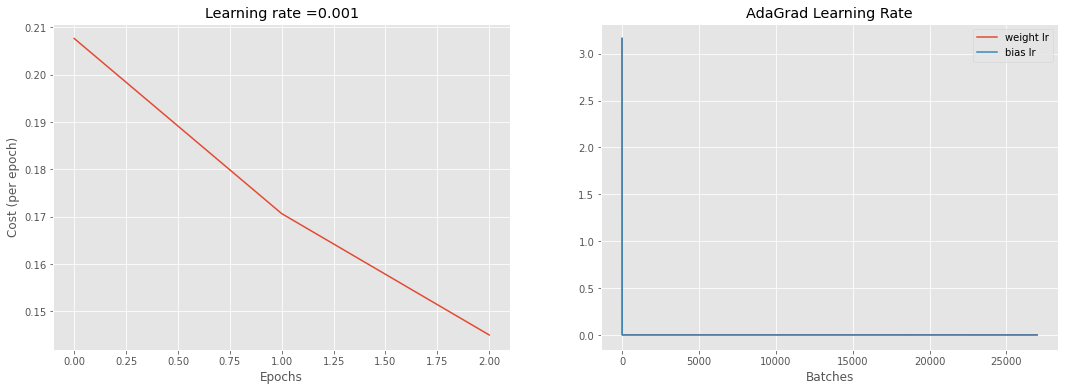

In [40]:
param2 = nn2.fit(X_train, y_train_one_hot)

In [41]:
nn2.accuracy(X_train, y_train, X_test, y_test, param2)

Training set accuracy: 71.13%
Testing set accuracy: 71.72%


It seems like the activation function is the one that affect the model's performance the most.

**Model 3**

We are back to tanh function again, but now we change the number of hidden layers, number of nodes.

Number of hidden layers: 5

Layers size: [Input, 750, 500, 400, 200, 10]

Batch size: 20

Learning rate: 0.001

Number of epochs: 3

Hidden layer estimator: Tanh

Output layer estimator: ReLu

In [43]:
layers = [X_train.shape[0], 750, 500, 400, 200, 10]
lr = 0.001
batch = 20
epochs = 3

nn3 = ScratchDeepNeuralNetrowkClassifier(layers, lr=lr, hidden_est='tanh', output_est='relu', batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iteration: 3000.0
Cost after epoch 0: 0.27336462529651656
Cost after epoch 1: 0.26822395076501987
Cost after epoch 2: 0.2064427916995916


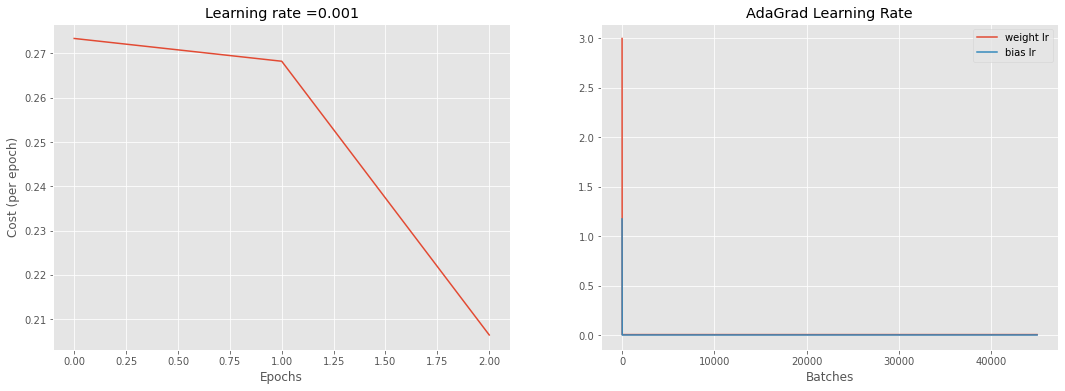

In [44]:
param3 = nn3.fit(X_train, y_train_one_hot)

In [45]:
nn3.accuracy(X_train, y_train, X_test, y_test, param3)

Training set accuracy: 32.61%
Testing set accuracy: 32.93%


Turns out that the increase in hidden layers and number of nodes may cause the overfitting to our model, and it takes a lot of time for propagation to do its work.

**Model 4**

We will use only 3 layers similar to the first model, and change number of epochs from 3 to 5.

Number of hidden layers: 3

Layers size: [Input, 400, 250, 10]

Batch size: 20

Learning rate: 0.001

Number of epochs: 5

Hidden layer estimator: Tanh

Output layer estimator: ReLu

In [55]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.001
batch = 20
epochs = 5

nn4 = ScratchDeepNeuralNetrowkClassifier(layers, lr=lr, hidden_est='tanh', output_est='relu', batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iteration: 3000.0
Cost after epoch 0: 0.3363386379826091
Cost after epoch 1: 0.08370171166821556
Cost after epoch 2: 0.060859340996741604
Cost after epoch 3: 0.0501030206080957
Cost after epoch 4: 0.04329234929933288


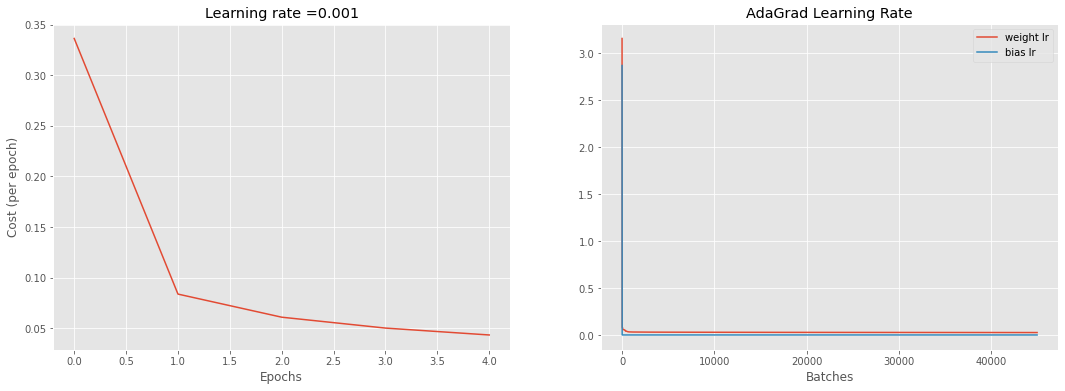

In [56]:
param4 = nn4.fit(X_train, y_train_one_hot)

In [57]:
nn4.accuracy(X_train, y_train, X_test, y_test, param4)

Training set accuracy: 94.46%
Testing set accuracy: 94.16%


The output match with my expectation, in which the number of epochs will affect the learning pattern of our model and parameters. The more epochs means the more time to re-train the batch. Therefore, each weight and bias values might gradually potentially become the best ones.

**Model 5**

This is our final model. Here, I increase the number of epochs to 10

Number of hidden layers: 3

Layers size: [Input, 400, 250, 10]

Batch size: 20

Learning rate: 0.001

Number of epochs: 10

Hidden layer estimator: Tanh

Output layer estimator: ReLu

In [59]:
layers = [X_train.shape[0], 400, 200, 10]
lr = 0.001
batch = 20
epochs = 10

nn5 = ScratchDeepNeuralNetrowkClassifier(layers, lr=lr, hidden_est='tanh', output_est='relu', batch_size=batch, epochs=epochs, verbose=True)

Batch size: 20
Iteration: 3000.0
Cost after epoch 0: 0.3363386379826091
Cost after epoch 1: 0.08370171166821556
Cost after epoch 2: 0.060859340996741604
Cost after epoch 3: 0.0501030206080957
Cost after epoch 4: 0.04329234929933288
Cost after epoch 5: 0.03804123131474752
Cost after epoch 6: 0.03469065809242787
Cost after epoch 7: 0.03172574117048957
Cost after epoch 8: 0.029307538347788074
Cost after epoch 9: 0.027007562769562336


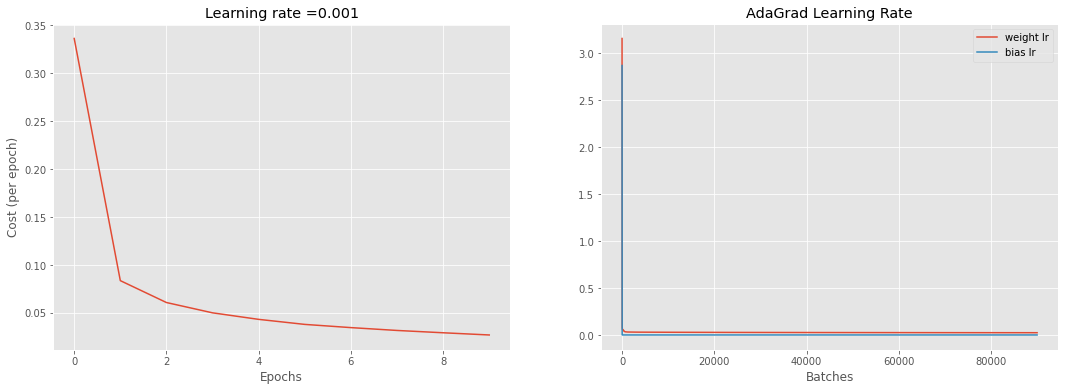

In [60]:
param5 = nn5.fit(X_train, y_train_one_hot)

In [61]:
nn5.accuracy(X_train, y_train, X_test, y_test, param5)

Training set accuracy: 96.46%
Testing set accuracy: 95.8%


In conclusion, my personal comments on the behavior of neural network model are:

* The hidden layers only show its benefit when we come up with a very large of dataset. This is because it requires huge number of nodes to fit with the training data. Otherwise, using too many hidden layers or number of nodes may cause overfitting

* Config the number of epochs is important. Because the more epochs, the better the iterative training works out. In fact, parameters need to be updated in a way that reducing the loss as much as possible. Therefore, if we train the data a little bit more, there is a high chance that loss will be decrease a little bit, thus enabling the parameters (weight and bias) find their best values.

* Learning rate is also very important. During this assignment, I have tried to use the learning rate 0.01 and more. However, it informed me a warning showing that the logarithm function witnessed the division of zero, or the exponential function witnessed the overflow. This is maybe due to the high learning rate, in which it cause the parameters to be update too fast, thus the undesireable divergent may occurs during the training process.

* The tanh function has a better performance than sigmoid function. This is due to the range of tanh ([-1:1]) is higher than that of sigmoid ([0:1]). Convergence is usually faster if the average of each input variable over the training set is close to zero. In this case, sigmoid maps a strongly-negative input to an output value that close to zero (due to its boundary [0:1]), thus making the update in backpropagation to be slower. At this point, our neural network might also get stuck during the training. On the contrary, tanh maps the input to the output in a range of (-1,1), that is, maps a strongly-negative input to negative output and vice versa. As a result, the neural network can update the parameters and converge faster.